# Peer Graded Assignment: Прогнозирование уровня средней заработной платы в России

### Подготовительные шаги

In [1]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


In [2]:
#Для русских надписей на графиках (найдено в интернетах)
from matplotlib import rc
font = {'family': 'Arial',
        'weight': 'normal',
        'size': 14}
rc('font', **font)

In [4]:
#Средняя номинальная заработная плата (WAG_C_M)
data = pd.read_csv('../WAG_C_M.csv', ';', index_col=['month'], parse_dates=['month'], dayfirst=True)

In [5]:
data.head()

,WAG_C_M
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


### Визуальный анализ ряда

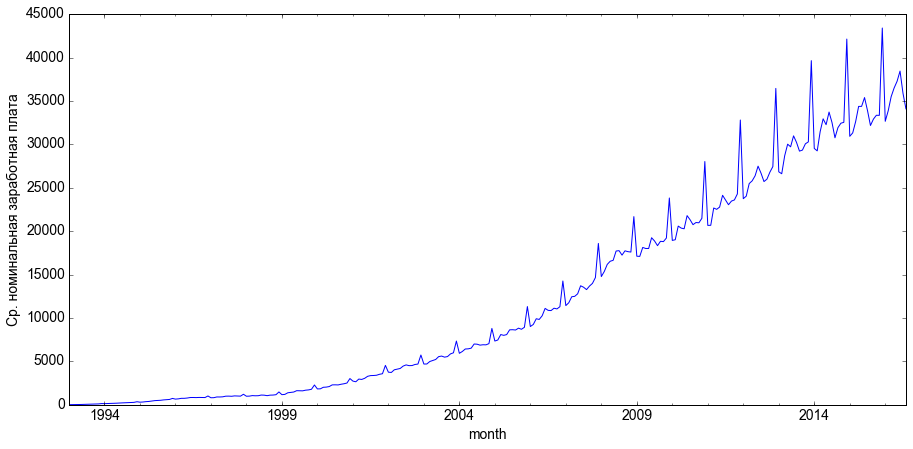

In [6]:
plt.figure(figsize(15,7))
#data.WAG_C_M = data.WAG_C_M*100
data.WAG_C_M.plot()
plt.ylabel(u'Ср. номинальная заработная плата')
pylab.show()

Мы наблюдаем:
созонность, цикличность, тренд, меняется дисперсия со временем => ряд не стационарен

Начать надо с сезонности. Далее, в случае необходимости возьмемся за стабилизацию дисперсии.

Попробуем проверить ряд на стационарность по критерию Дики-Фуллера и проведем STL-декомпозицию ряда.

Критерий Дики-Фуллера: p=0.991850


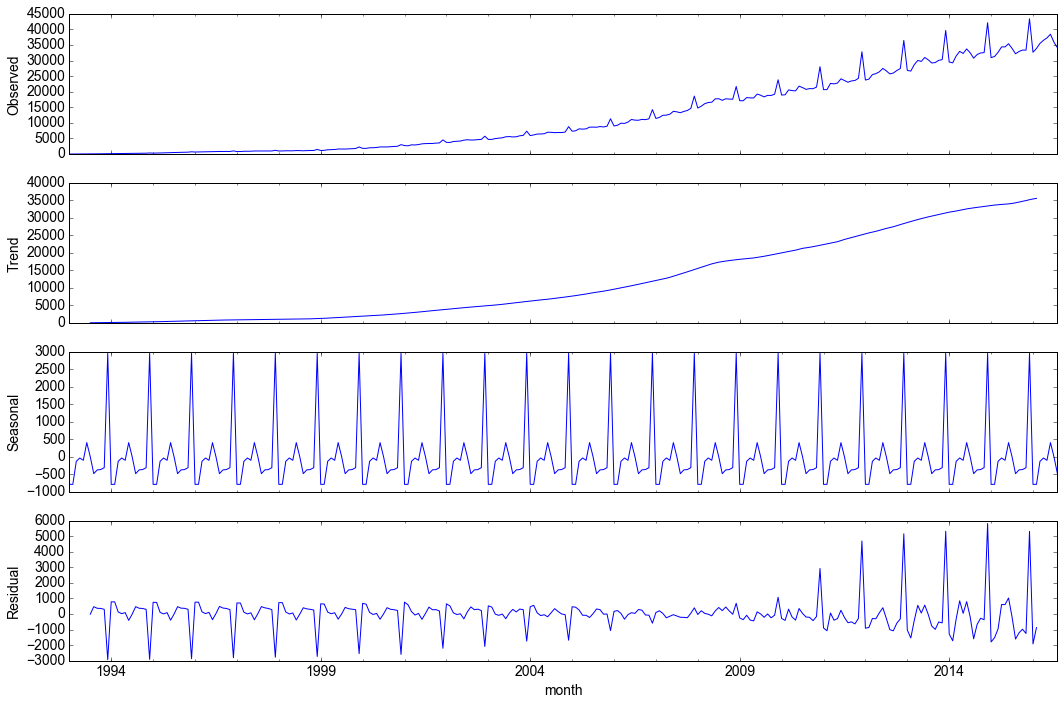

In [7]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.WAG_C_M).plot()
print ("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.WAG_C_M)[1])

Критерий Дики-Фуллера (p=0.991850) значимо больше фльфа = 0.05. Это указвает нам на то что мы не можем отвергнуть геипотезу H0 о том что ряд не стационарен.

### Стабилизация дисперсии (при необходимости)

Оптимальный параметр преобразования Бокса-кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


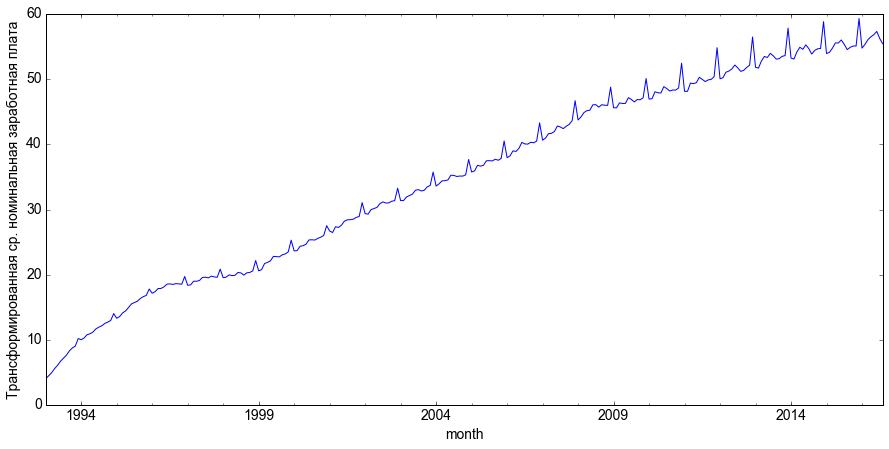

In [8]:
data['WAG_C_M_box'], lmbda = stats.boxcox(data.WAG_C_M)
plt.figure(figsize(15,7))
data.WAG_C_M_box.plot()
plt.ylabel(u'Трансформированная ср. номинальная заработная плата')
print ("Оптимальный параметр преобразования Бокса-кокса: %f" % lmbda)
print ("Критерий Дики-Фуллера: p=%f" % 
       sm.tsa.stattools.adfuller(data.WAG_C_M_box)[1])

### Выбор порядка дифференцирования

Критерий Дики-Фуллера : p=0.014697


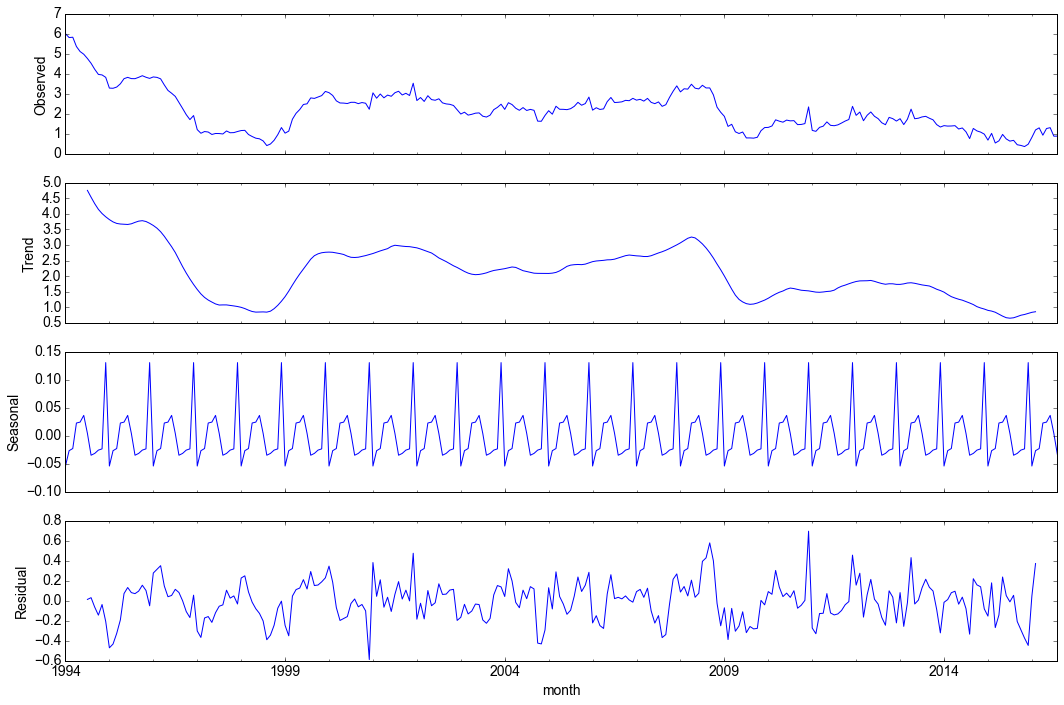

In [9]:
data['WAG_C_M_box_diff'] = data.WAG_C_M_box - data.WAG_C_M_box.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.WAG_C_M_box_diff[12:]).plot()
print ("Критерий Дики-Фуллера : p=%f" % sm.tsa.stattools.adfuller(data.WAG_C_M_box_diff[12:])[1])

Критерий Дики-Фуллера : p=0.000000


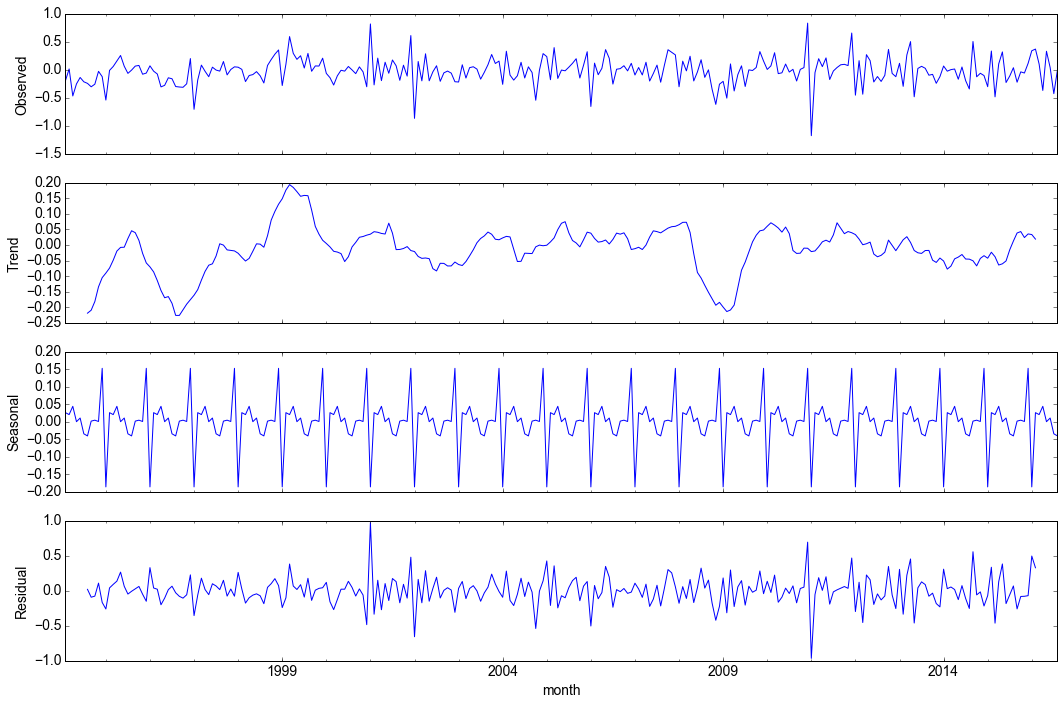

In [10]:
data['WAG_C_M_box_diff2'] = data.WAG_C_M_box_diff - data.WAG_C_M_box_diff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.WAG_C_M_box_diff2[13:]).plot()
print ("Критерий Дики-Фуллера : p=%f" % sm.tsa.stattools.adfuller(data.WAG_C_M_box_diff2[13:])[1])

Критерий Дики-Фуллера указывает на то что теперь ряд стационарен.

### Выбор начальных приближений для p,q,P,Q

Посмотрим на ACF и PACF полученного ряда

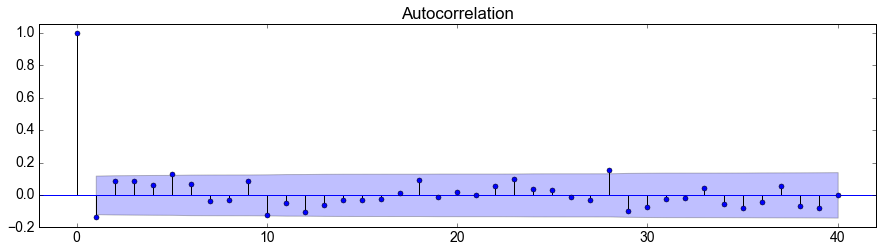

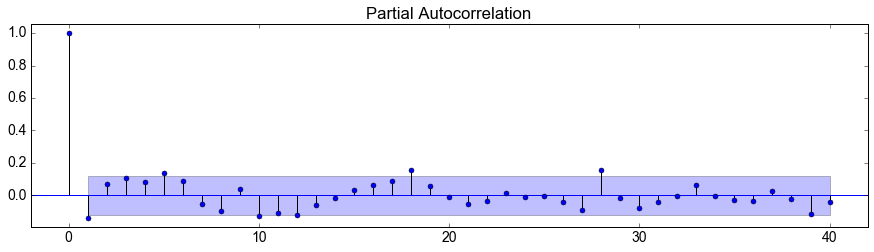

In [11]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data.WAG_C_M_box_diff2[13:].values.squeeze(), lags=40, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data.WAG_C_M_box_diff2[13:].values.squeeze(), lags=40, ax=ax)
pylab.show()

Начальные приближения: Q=1, q=0, P=1, p=0

In [12]:
ps = range(0, 3)
d=1
qs = range(0, 3)
Ps = range(1, 3)
D=1
Qs = range(1, 3)

In [13]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

36

### Обучение и сравнение моделей-кандидатов, выбор победителя

In [14]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data.WAG_C_M_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print ('wrong parameters:', param)
        continue
    except  numpy.linalg.linalg.LinAlgError:## было одно исключение на данную тему
        print ('wrong parameters/SingularMatrix:', param) 
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

('wrong parameters:', (1, 2, 1, 1))
('wrong parameters:', (1, 2, 1, 2))
('wrong parameters:', (1, 2, 2, 1))
('wrong parameters:', (1, 2, 2, 2))
('wrong parameters:', (2, 1, 1, 1))
('wrong parameters:', (2, 1, 1, 2))
('wrong parameters:', (2, 1, 2, 1))
('wrong parameters:', (2, 1, 2, 2))
('wrong parameters:', (2, 2, 1, 1))
('wrong parameters:', (2, 2, 1, 2))
('wrong parameters:', (2, 2, 2, 1))
('wrong parameters:', (2, 2, 2, 2))
Wall time: 1min 44s


In [15]:
print (best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                        WAG_C_M_box   No. Observations:                  284
Model:             SARIMAX(1, 1, 0)x(2, 1, 2, 12)   Log Likelihood                   6.837
Date:                            Thu, 29 Sep 2016   AIC                             -1.674
Time:                                    12:51:14   BIC                             20.220
Sample:                                01-01-1993   HQIC                             7.103
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1431      0.051     -2.783      0.005      -0.244      -0.042
ar.S.L12       0.5821      0.292   

### Анализ остатков построенной модели

Критерий Стьюдента: p=0.565062
Критерий Дики-Фуллера: p=0.000155


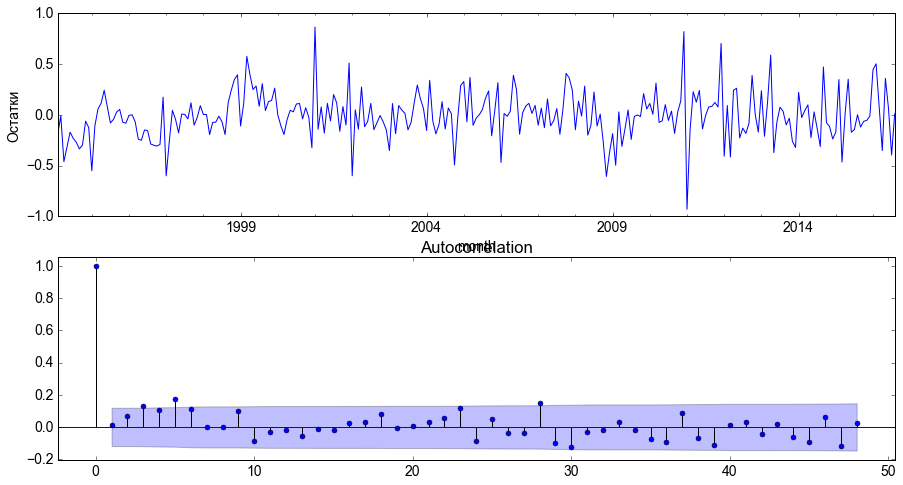

In [16]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Остатки')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print ("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print ("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

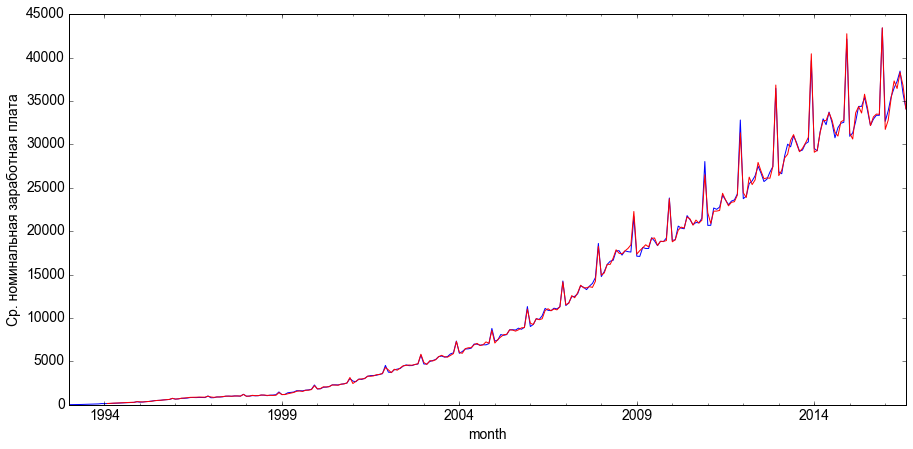

In [17]:
data['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
data.WAG_C_M.plot()
data.model[13:].plot(color='r')
plt.ylabel(u'Ср. номинальная заработная плата')
pylab.show()

### Прогнозирование с помощью финальной модели.

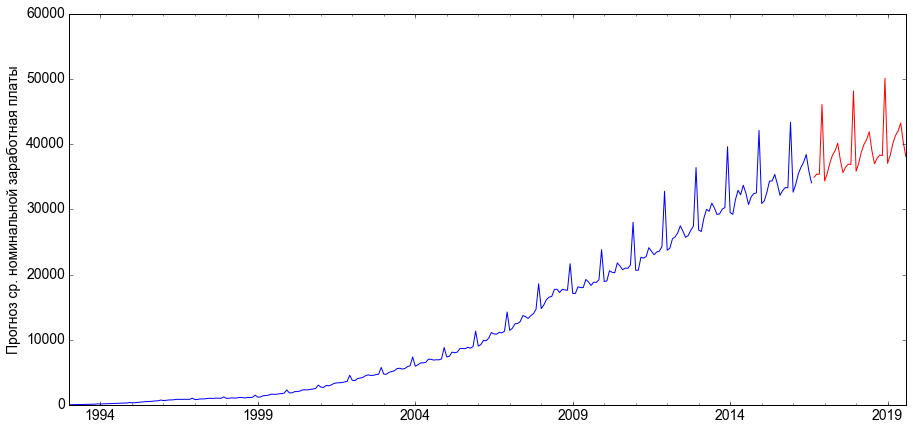

In [18]:
data2 = data[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2016-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns= data2.columns)
data2 = pd.concat([data2, future])
data2['forecast'] = invboxcox(best_model.predict(start=284, end=320), lmbda)

plt.figure(figsize(15,7))
data2.WAG_C_M.plot()
data2.forecast.plot(color='r')
plt.ylabel(u'Прогноз ср. номинальной заработная платы')
pylab.show()